## AIPI 590 - XAI | Assignment #2
### Adversarial Patch Creation
#### Developed by Tal Erez
#### Colab Notebook:
[![Open In Collab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/notthattal/AdversarialAI_Patch/blob/main/adversarial_patch.ipynb#scrollTo=jv7U4G4FodQf)

### Introduction

This notebook uses a small version of the ImageNet library to train an adversarial patch to fool the AI into thinking all images are the same animal.

To increase robustness, random rotation and random scaling can be introduced by modifying the rotate and scale variables in the patch_attack() function. I chose to focus on one target class to keep consistency amongst different training attempts. A discussion of some of the results of these modifiers is present at the end of the notebook.

### Step 1: Install the required dependencies and import the required packages

In [2]:
!pip install torch torchvision adversarial-robustness-toolbox matplotlib pytorch-lightning ipywidgets tabulate

#from google.colab import userdata
from google.colab import userdata
from IPython.display import display, HTML
import json
import matplotlib.pyplot as plt
import numpy as np
import os
from PIL import Image
import pytorch_lightning as pl
import tabulate
import torch
import torch.nn as nn
import torchvision
import torchvision.transforms as transforms
import torchvision.transforms.functional as TF
import torchvision.models as models
import torch.utils.data as data
from tqdm.notebook import tqdm
import urllib.request
from urllib.error import HTTPError
import zipfile

  Using cached jedi-0.19.1-py2.py3-none-any.whl.metadata (22 kB)
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 26.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 815.2/815.2 kB 34.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 866.2/866.2 kB 38.5 MB/s eta 0:00:00
Using cached jedi-0.19.1-py2.py3-none-any.whl (1.6 MB)


### Step 2: Connect the Github repository to the Google Colab Notebook

In [20]:
# Remove Colab default sample_data

# Check if the repo already exists
if os.path.exists("./sample_data"):
    !rm -r ./sample_data

# Clone GitHub files to colab workspace
repo_name = "AdversarialAI_Patch" # Change to your repo name

# Check if the repo already exists
if not os.path.exists("/content/" + repo_name):
    git_path = 'https://github.com/notthattal/AdversarialAI_Patch.git' #Change to your path
    !git clone "{git_path}"
else:
    print(f"{repo_name} already exists.")

# Change working directory to location of notebook
path_to_notebook = os.path.join("/content/" + repo_name)
%cd "{path_to_notebook}"
%ls

AdversarialAI_Patch already exists.
/content/AdversarialAI_Patch
adversarial_patch.ipynb  premade_patches/  README.md  saved_models/  test/


### Step 3: Create Environment Variables

### Step 4: Set the Seed, ensure operations are deterministic on the GPU and set the device

In [12]:
# Setting the seed
pl.seed_everything(42)


device = None

# Fetching the device that will be used throughout this notebook
if torch.backends.mps.is_available():
    # Ensure that all operations are deterministic on GPU (if used) for reproducibility
    torch.use_deterministic_algorithms(True)

    #set device to use mps
    device = torch.device("mps")
elif torch.cuda.is_available():
    # Ensure that all operations are deterministic on GPU (if used) for reproducibility
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

    #set device to use cuda
    device = torch.device("cuda:0")
else:
    #set device to use the cpu
    device = torch.device("cpu")

print("Using device", device)

INFO:lightning_fabric.utilities.seed:Seed set to 42


Using device cuda:0


### Step 5: Download the dataset

In [23]:
# Github URL where the dataset is stored for this tutorial
base_url = "https://raw.githubusercontent.com/phlippe/saved_models/main/tutorial10/"

# Create paths if they don't exist yet
os.makedirs(userdata.get('DATASET_PATH'), exist_ok=True)
os.makedirs(userdata.get('CHECKPOINT_PATH'), exist_ok=True)
os.makedirs(userdata.get('IMAGE_PATH'), exist_ok=True)

# For each file, check whether it already exists. If not, try downloading it.
file_name = "TinyImageNet.zip"
file_path = os.path.join(userdata.get('DATASET_PATH'), file_name)
if not os.path.isfile(file_path):
    file_url = base_url + file_name
    print(f"Downloading {file_url}...")
    try:
        urllib.request.urlretrieve(file_url, file_path)
    except HTTPError as e:
        print("Something went wrong. Please try to download the file from the GDrive folder, or contact the author with the full output including the following error:\n", e)
    if file_name.endswith(".zip"):
        print("Unzipping file...")
        with zipfile.ZipFile(file_path, 'r') as zip_ref:
            zip_ref.extractall(file_path.rsplit("/",1)[0])
            print("Unzip complete")

### Step 6: Load the ImageNet Model

In [24]:
# Load a pre-trained ResNet-34 model with ImageNet weights
pretrained_model = models.resnet34(weights='IMAGENET1K_V1')
pretrained_model = pretrained_model.to(device)

# Set model to evaluation mode
pretrained_model.eval()

Downloading: "https://download.pytorch.org/models/resnet34-b627a593.pth" to ./saved_models/hub/checkpoints/resnet34-b627a593.pth
100%|██████████| 83.3M/83.3M [00:00<00:00, 145MB/s]


ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

### Step 6: Load the Dataset and Label Names
  - set the transform
  - load the dataset using the created transform and create the data loader
  - load the label names

In [26]:
# Set the Mean and Std from ImageNet
NORM_MEAN = np.array([0.485, 0.456, 0.406])
NORM_STD = np.array([0.229, 0.224, 0.225])

# Convert the input image to PyTorch Tensor and normalize the images using the mean and standard deviation above
plain_transforms = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=NORM_MEAN,
                         std=NORM_STD)
])

# Load dataset and create data loader
imagenet_path = os.path.join(userdata.get('DATASET_PATH'), "TinyImageNet/")
assert os.path.isdir(imagenet_path), f"Could not find the ImageNet dataset at expected path \"{imagenet_path}\". " + \
                                     f"Please make sure to have downloaded the ImageNet dataset here, or change the {DATASET_PATH=} variable."
dataset = torchvision.datasets.ImageFolder(root=imagenet_path, transform=plain_transforms)
data_loader = data.DataLoader(dataset, batch_size=32, shuffle=False, drop_last=False, num_workers=8)

# Load label names to interpret the label numbers 0 to 999
with open(os.path.join(imagenet_path, "label_list.json"), "r") as f:
    label_names = json.load(f)

/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


### Step 8: Map patch values to ImageNet min and max
  - Convert the NORM_MEAN and NORM_STD to PyTorch tensors
  - Create a function "patch_forward" which converts the patch values from [-∞,∞] to ImageNet's [min, max]

In [27]:
TENSOR_MEANS, TENSOR_STD = torch.FloatTensor(NORM_MEAN)[:,None,None], torch.FloatTensor(NORM_STD)[:,None,None]
def patch_forward(patch):
    # Map patch values from [-infty,infty] to ImageNet min and max
    patch = (torch.tanh(patch) + 1 - 2 * TENSOR_MEANS) / (2 * TENSOR_STD)
    return patch

### Step 9: Create function which modifies the image for training
  - Places the patch in a random location in the image
  - If training the patch, will apply a random rotation for robustness

In [28]:
def place_patch(img, patch, training=False, rotate=0, scale=1):
    for i in range(img.shape[0]):

        # Apply random rotation to the patch if training
        final_patch = patch
        if training:
            #angle = np.random.uniform(0, 360)
            final_patch = TF.rotate(patch, rotate)

            new_size = [int(final_patch.shape[1] * scale), int(final_patch.shape[2] * scale)]
            final_patch = TF.resize(final_patch, new_size)

        # Apply random placement of the patch regardless of training or testing
        h_offset = np.random.randint(0,img.shape[2]-final_patch.shape[1]-1)
        w_offset = np.random.randint(0,img.shape[3]-final_patch.shape[2]-1)

        # Set the new transformation of the patch
        img[i,:,h_offset:h_offset+final_patch.shape[1],w_offset:w_offset+final_patch.shape[2]] = patch_forward(final_patch)
    return img

### Step 10: Create function to evaluate the model
  - Create a function that validates the effectiveness of the patch in fooling the model into predicting the target class
  - The function excludes images in the target class
  - Averages performance among 4 random placements and returns the accuracy metrics

In [29]:
def eval_patch(model, patch, val_loader, target_class):
    model.eval()
    tp, tp_5, counter = 0., 0., 0.
    with torch.no_grad():
        for img, img_labels in tqdm(val_loader, desc="Validating...", leave=False):
            # For stability, place the patch at 4 random locations per image, and average the performance
            for _ in range(4):
                patch_img = place_patch(img, patch)
                patch_img = patch_img.to(device)
                img_labels = img_labels.to(device)
                pred = model(patch_img)
                # In the accuracy calculation, we need to exclude the images that are of our target class
                # as we would not "fool" the model into predicting those
                tp += torch.logical_and(pred.argmax(dim=-1) == target_class, img_labels != target_class).sum()
                tp_5 += torch.logical_and((pred.topk(5, dim=-1)[1] == target_class).any(dim=-1), img_labels != target_class).sum()
                counter += (img_labels != target_class).sum()
    acc = tp/counter
    top5 = tp_5/counter
    return acc, top5

### Step 11: Attack the Image
  - Creates a function "patch_attack" which is used to train a model to create a patch that fools a model into predicting a specific target class
  - Trains it over a specified number of epochs and evaluates the patch effectiveness on a validation set

In [30]:
def patch_attack(model, target_class, patch_size=64, num_epochs=5):
    # Leave a small set of images out to check generalization
    # In most of our experiments, the performance on the hold-out data points
    # was as good as on the training set. Overfitting was little possible due
    # to the small size of the patches.
    train_set, val_set = torch.utils.data.random_split(dataset, [4500, 500])
    train_loader = data.DataLoader(train_set, batch_size=32, shuffle=True, drop_last=True, num_workers=8)
    val_loader = data.DataLoader(val_set, batch_size=32, shuffle=False, drop_last=False, num_workers=4)

    # Create parameter and optimizer
    if not isinstance(patch_size, tuple):
        patch_size = (patch_size, patch_size)
    patch = nn.Parameter(torch.zeros(3, patch_size[0], patch_size[1]), requires_grad=True)
    optimizer = torch.optim.SGD([patch], lr=1e-1, momentum=0.8)
    loss_module = nn.CrossEntropyLoss()

    # Training loop
    for epoch in range(num_epochs):
        t = tqdm(train_loader, leave=False)
        scale = np.random.uniform(1, 1)
        for img, _ in t:
            rotate = np.random.uniform(0, 360)
            img = place_patch(img, patch, True, rotate, scale)
            img = img.to(device).to(next(model.parameters()).dtype)
            pred = model(img)
            labels = torch.zeros(img.shape[0], device=pred.device, dtype=torch.long).fill_(target_class)
            loss = loss_module(pred, labels)
            optimizer.zero_grad()
            loss.mean().backward()
            optimizer.step()
            t.set_description(f"Epoch {epoch}, Loss: {loss.item():4.2f}")

    # Final validation
    acc, top5 = eval_patch(model, patch, val_loader, target_class)

    return patch.data, {"acc": acc.item(), "top5": top5.item()}

### Step 12: Get the patch/patches
  - Main training function for the model
  - for each target class we want to generate a patch for, and for each patch size we want to generate, we train the model

In [31]:
def get_patches(class_names, patch_sizes, num_epochs=5):
    result_dict = dict()

    # Loop over all classes and patch sizes
    for name in class_names:
        result_dict[name] = dict()
        for patch_size in patch_sizes:
            c = label_names.index(name)
            file_name = os.path.join(userdata.get('CHECKPOINT_PATH'), f"{name}_{patch_size}_patch.pt")

            # Delete patch if pretrained file exists
            if os.path.isfile(file_name):
                os.remove(file_name)

            # Start training
            patch, val_results = patch_attack(pretrained_model, target_class=c, patch_size=patch_size, num_epochs=num_epochs)
            print(f"Validation results for {name} and {patch_size}:", val_results)
            torch.save(patch, file_name)

            # Load evaluation results if exist, otherwise manually evaluate the patch
            results = eval_patch(pretrained_model, patch, data_loader, target_class=c)

            # Store results and the patches in a dict for better access
            result_dict[name][patch_size] = {
                "results": results,
                "patch": patch
            }

    return result_dict

### Step 13: Start Training
  - Set the target classes for which to create patches
  - Set the patch sizes to be trained
  - Start the training loop

In [32]:
class_names = ["bulbul"]
patch_sizes = [64]

patch_dict = get_patches(class_names, patch_sizes, num_epochs=1)

/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


  0%|          | 0/140 [00:00<?, ?it/s]

Validating...:   0%|          | 0/16 [00:00<?, ?it/s]

Validation results for bulbul and 64: {'acc': 0.0010000000474974513, 'top5': 0.014000000432133675}


Validating...:   0%|          | 0/157 [00:00<?, ?it/s]

### Step 14: Display the patch/patches
  - Create a plot for every patch created
  - Display each plot

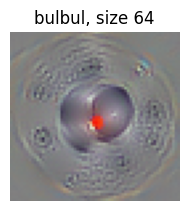

In [33]:
def show_patches(class_name, patch_size):
    fig, ax = plt.subplots(figsize=(2.2, 2.2))
    patch = patch_dict[class_name][patch_size]["patch"]
    patch = (torch.tanh(patch) + 1) / 2 # Parameter to pixel values
    patch = patch.cpu().permute(1, 2, 0).numpy()
    patch = np.clip(patch, a_min=0.0, a_max=1.0)

    # Save the patch in the specified directory
    save_path = os.path.join(userdata.get('IMAGE_PATH'), f"patch_{class_name}_{patch_size}.jpg")
    plt.imsave(save_path, patch)

    ax.imshow(patch)
    ax.set_title(f"{class_name}, size {patch_size}")
    ax.axis('off')
    fig.subplots_adjust(hspace=0.3, wspace=0.3)
    plt.show()

for size in patch_sizes:
    for name in class_names:
        show_patches(name, size)

### Step 15: Create HTML code to set the font size for the following table

In [ ]:
%%html
<!-- Some HTML code to increase font size in the following table -->
<style>
th {font-size: 120%;}
td {font-size: 120%;}
</style>

### Step 16: Display Patch Attack Performance
  - Set the font size for the table
  - Generate a table showing patch_attack performance

In [ ]:
def show_table(top_1=True):
    i = 0 if top_1 else 1
    table = [[name] + [f"{(100.0 * patch_dict[name][psize]['results'][i]):4.2f}%" for psize in patch_sizes]
             for name in class_names]
    display(HTML(tabulate.tabulate(table, tablefmt='html', headers=["Class name"] + [f"Patch size {psize}x{psize}" for psize in patch_sizes])))

show_table(top_1=False)

### Step 17: Visualize the predictions
  - Create a plot for a specified number of images
  - display the image with the embedded patch
  - show a bar graph with the model's top predictions

In [ ]:
def show_prediction(img, label, pred, index, K=5, adv_img=None, noise=None):

    if isinstance(img, torch.Tensor):
        # Tensor image to numpy
        img = img.cpu().permute(1, 2, 0).numpy()
        img = (img * NORM_STD[None,None]) + NORM_MEAN[None,None]
        img = np.clip(img, a_min=0.0, a_max=1.0)
        label = label.item()

    # Plot on the left the image with the true label as title.
    # On the right, have a horizontal bar plot with the top k predictions including probabilities
    if noise is None or adv_img is None:
        fig, ax = plt.subplots(1, 2, figsize=(10,2), gridspec_kw={'width_ratios': [1, 1]})
    else:
        fig, ax = plt.subplots(1, 5, figsize=(12,2), gridspec_kw={'width_ratios': [1, 1, 1, 1, 2]})

    save_path = userdata.get('IMAGE_PATH') + str(index) + ".jpg"
    if save_path is not None:
        img_pil = Image.fromarray((img * 255).astype(np.uint8))  # Convert from [0,1] to [0,255] and uint8
        img_pil.save(save_path, format='JPEG')

    ax[0].imshow(img)
    ax[0].set_title(label_names[label])
    ax[0].axis('off')

    if adv_img is not None and noise is not None:
        # Visualize adversarial images
        adv_img = adv_img.cpu().permute(1, 2, 0).numpy()
        adv_img = (adv_img * NORM_STD[None,None]) + NORM_MEAN[None,None]
        adv_img = np.clip(adv_img, a_min=0.0, a_max=1.0)
        ax[1].imshow(adv_img)
        ax[1].set_title('Adversarial')
        ax[1].axis('off')
        # Visualize noise
        noise = noise.cpu().permute(1, 2, 0).numpy()
        noise = noise * 0.5 + 0.5 # Scale between 0 to 1
        ax[2].imshow(noise)
        ax[2].set_title('Noise')
        ax[2].axis('off')
        # buffer
        ax[3].axis('off')

    if abs(pred.sum().item() - 1.0) > 1e-4:
        pred = torch.softmax(pred, dim=-1)
    topk_vals, topk_idx = pred.topk(K, dim=-1)
    topk_vals, topk_idx = topk_vals.cpu().numpy(), topk_idx.cpu().numpy()
    ax[-1].barh(np.arange(K), topk_vals*100.0, align='center', color=["C0" if topk_idx[i]!=label else "C2" for i in range(K)])
    ax[-1].set_yticks(np.arange(K))
    ax[-1].set_yticklabels([label_names[c] for c in topk_idx])
    ax[-1].invert_yaxis()
    ax[-1].set_xlabel('Confidence')
    ax[-1].set_title('Predictions')

    plt.show()
    plt.close()

### Step 18: Retrieve input data and labels from data_loader

In [ ]:
exmp_batch, label_batch = next(iter(data_loader))

### Step 19: Predict and display predictions for a specified number of examples

In [ ]:
def perform_patch_attack(patch):
    patch_batch = exmp_batch.clone()
    patch_batch = place_patch(patch_batch, patch)
    with torch.no_grad():
        patch_preds = pretrained_model(patch_batch.to(device))
    for i in range(1,10):
        show_prediction(patch_batch[i], label_batch[i], patch_preds[i], i)

perform_patch_attack(patch_dict['bulbul'][64]['patch'])

### Discussion

In order to determine which patch was the most effective, and to try to improve the robustness and accuracy to which the created patch was successful I modified the learning algorithm in multiple ways to test efficiency.

For testing purposes, I attempted to create a patch using SGD and the Adam optimizer. The Adam optimizer consistently resulted in lower accuracy, so I determined that I should stick with using the SGD optimizer.

Once the optimizer was decided upon, I attempted to modify the learning rate in a few different ways. First was just decreasing the learning rate from 1e-1 to 1e-2 and the second was to try and use learning rate scheduling. But, ultimately 1e-1 proved to result in the highest accuracy. Similarly, modifying the momentum, introducing weight decays and modifying the loss function all resulted in lower accuracy than the base model set in the tutorial.

To increase robustness, I introduced a random rotation and random scaling. For each, the base model, rotation without scaling and rotation with scaling I have generated patches are presented below along with their overall accuracy % as reported by the eval_patch() function.

#### Base (No Rotation or Scaling):

5 epochs: 99.92% <br> <br>
![](https://github.com/notthattal/AdversarialAI_Patch/blob/main/premade_patches/patch_base_5.jpg?raw=1)

10 epochs: 99.98% accuracy <br> <br>
![](https://github.com/notthattal/AdversarialAI_Patch/blob/main/premade_patches/patch_base_10.jpg?raw=1)

#### Rotation No Scaling:
*Note: Rotations were in the range of 0 to 360 degrees.

10 epochs, but random rotation was only applied once per epoch: 87.89% accuracy <br> <br>
![](https://github.com/notthattal/AdversarialAI_Patch/blob/main/premade_patches/patch_rotate_epoch.jpg?raw=1)

10 epochs: 94.94% accuracy <br> <br>
![](https://github.com/notthattal/AdversarialAI_Patch/blob/main/premade_patches/patch_rotate_10.jpg?raw=1)

15 epochs: 97.42% accuracy <br> <br>
![](https://github.com/notthattal/AdversarialAI_Patch/blob/main/premade_patches/patch_rotate_15.jpg?raw=1)

#### Rotation And Scaling:
*Note: Scaling was performed once per epoch unless specified. Patches were scaled randomly from 0.5 to 1 times the original size and were applied for both the x and y axes of the image uniformly to keep the patch square.

10 epochs every step: 66.32% accuracy <br> <br>
![](https://github.com/notthattal/AdversarialAI_Patch/blob/main/premade_patches/patch_scaling_every_10.jpg?raw=1)

10 epochs: 73.65% accuracy <br> <br>
![](https://github.com/notthattal/AdversarialAI_Patch/blob/main/premade_patches/patch_scaling_10.jpg?raw=1)

25 epochs: 90.85% accuracy <br> <br>
![](https://github.com/notthattal/AdversarialAI_Patch/blob/main/premade_patches/patch_scaling_25.jpg?raw=1)

50 epochs: 95.95% accuracy <br> <br>
![](https://github.com/notthattal/AdversarialAI_Patch/blob/main/premade_patches/patch_scaling_50.jpg?raw=1)

Rotation and scaling was attempted due to the discussion in the tutorial referencing Brown et al. As we can see, the base model provided in the tutorial (with a slight bump to the number of epochs) resulted in the highest accuracy of prediction from the model. However, we see that with some modifications to the number of epochs and how we introduce scaling, we can still achieve a high level of accuracy with random scaling and rotations. Some surprising results were that although implementing scaling at every step lowered the accuracy, for rotation, applying it once per epoch instead of every step actually caused worse performance.

### Combining Patches
Along with testing multiple different types of patches, I also combined my patches to see if it was still able to fool the classifier. Here are the results:

Combining both base cases <br>
*Result: Correctly classified as Bulbul bird* <br> <br>
![](https://github.com/notthattal/AdversarialAI_Patch/blob/main/premade_patches/combo_base.jpg?raw=1) <br>

Combining all rotated images <br>
*Result: The model failed and classified the image as a house finch* <br> <br>
![](https://github.com/notthattal/AdversarialAI_Patch/blob/main/premade_patches/combo_rotate.jpg?raw=1) <br>

Combining all scaled images <br>
*Result: The model failed and classified the image as a barn spider* <br> <br>
![](https://github.com/notthattal/AdversarialAI_Patch/blob/main/premade_patches/combo_scale.jpg?raw=1) <br>

Combining all images which used 10 epochs (i.e. a base, rotated and a scaled image) <br>
*Result: The model failed and classified the image as a pillow* <br> <br>
![](https://github.com/notthattal/AdversarialAI_Patch/blob/main/premade_patches/combo_10.jpg?raw=1) <br>

### Citations
Lippe, Phillip, & Bent, Brinnae, PhD "Tutorial 10: Adversarial attacks." Github, 2024, https://github.com/AIPI-590-XAI/Duke-AI-XAI/blob/main/adversarial-ai-example-notebooks/adversarial_attacks.ipynb
